In [1]:
import pandas as pd
dublin_data = pd.read_csv('dublin_cleaned.csv')
dublin_data.head()

,NAME,STATION ID,TIME,BIKE_STANDS,BIKES_IN_USE,AVAILABLE_BIKES,LATITUDE,LONGITUDE,TRIPS,Day,Hour,TimeOfDay
0,CLARENDON ROW,1,2023-01-01 08:30:03,31,31,0,53.3409,-6.2625,1.0,Sunday,8,Morning
1,CLARENDON ROW,1,2023-01-01 13:00:02,31,29,2,53.3409,-6.2625,1.0,Sunday,13,Afternoon
2,CLARENDON ROW,1,2023-01-01 15:00:03,31,29,2,53.3409,-6.2625,1.0,Sunday,15,Afternoon
3,CLARENDON ROW,1,2023-01-01 16:00:02,31,29,2,53.3409,-6.2625,1.0,Sunday,16,Afternoon
4,CLARENDON ROW,1,2023-01-01 17:00:03,31,30,1,53.3409,-6.2625,1.0,Sunday,17,Afternoon


In [2]:
# Convert the 'TIME' column to datetime format and set it as the index
dublin_data['TIME'] = pd.to_datetime(dublin_data['TIME'])
dublin_data.set_index('TIME', inplace=True)

# Aggregate the data to daily sums of trips
daily_trips = dublin_data['TRIPS'].resample('D').sum()

# Display the first few rows of the aggregated data
daily_trips.head()

TIME
2023-01-01    1095.0
2023-01-02    1424.0
2023-01-03    2592.0
2023-01-04    2759.0
2023-01-05    2814.0
Freq: D, Name: TRIPS, dtype: float64

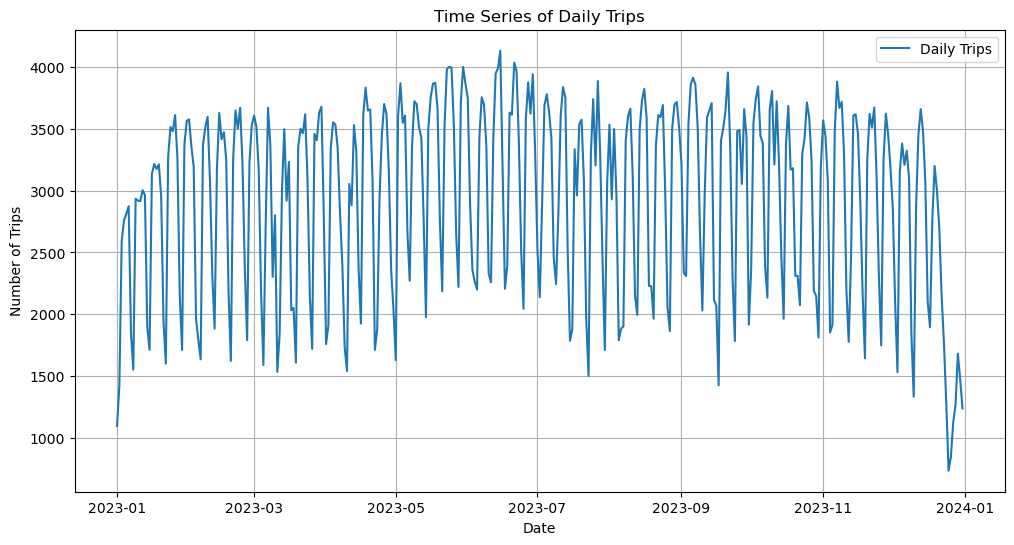

In [3]:
import matplotlib.pyplot as plt

# Plotting the daily trips
plt.figure(figsize=(12, 6))
plt.plot(daily_trips, label='Daily Trips')
plt.title('Time Series of Daily Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

Trend: The overall direction of the series over time. If there's a consistent upward or downward slope, it indicates a long-term increase or decrease in the number of trips.

Seasonality: Regular patterns or cycles of increase and decrease in the number of trips. This could be tied to factors like weekdays vs. weekends, holidays, weather conditions, or other seasonal events.

Variability: The fluctuations in the data points around the trend. High variability means large changes in the number of trips from day to day, while low variability indicates more consistent trip numbers.

Anomalies: Any unexpected spikes or dips that don't fit the usual pattern. These could be due to special events, disruptions, or other unusual occurrences.

Time Span and Frequency: The x-axis shows the time span covered by the data, with each point representing the sum of trips for a single day. This granularity helps in identifying daily patterns and changes over time.

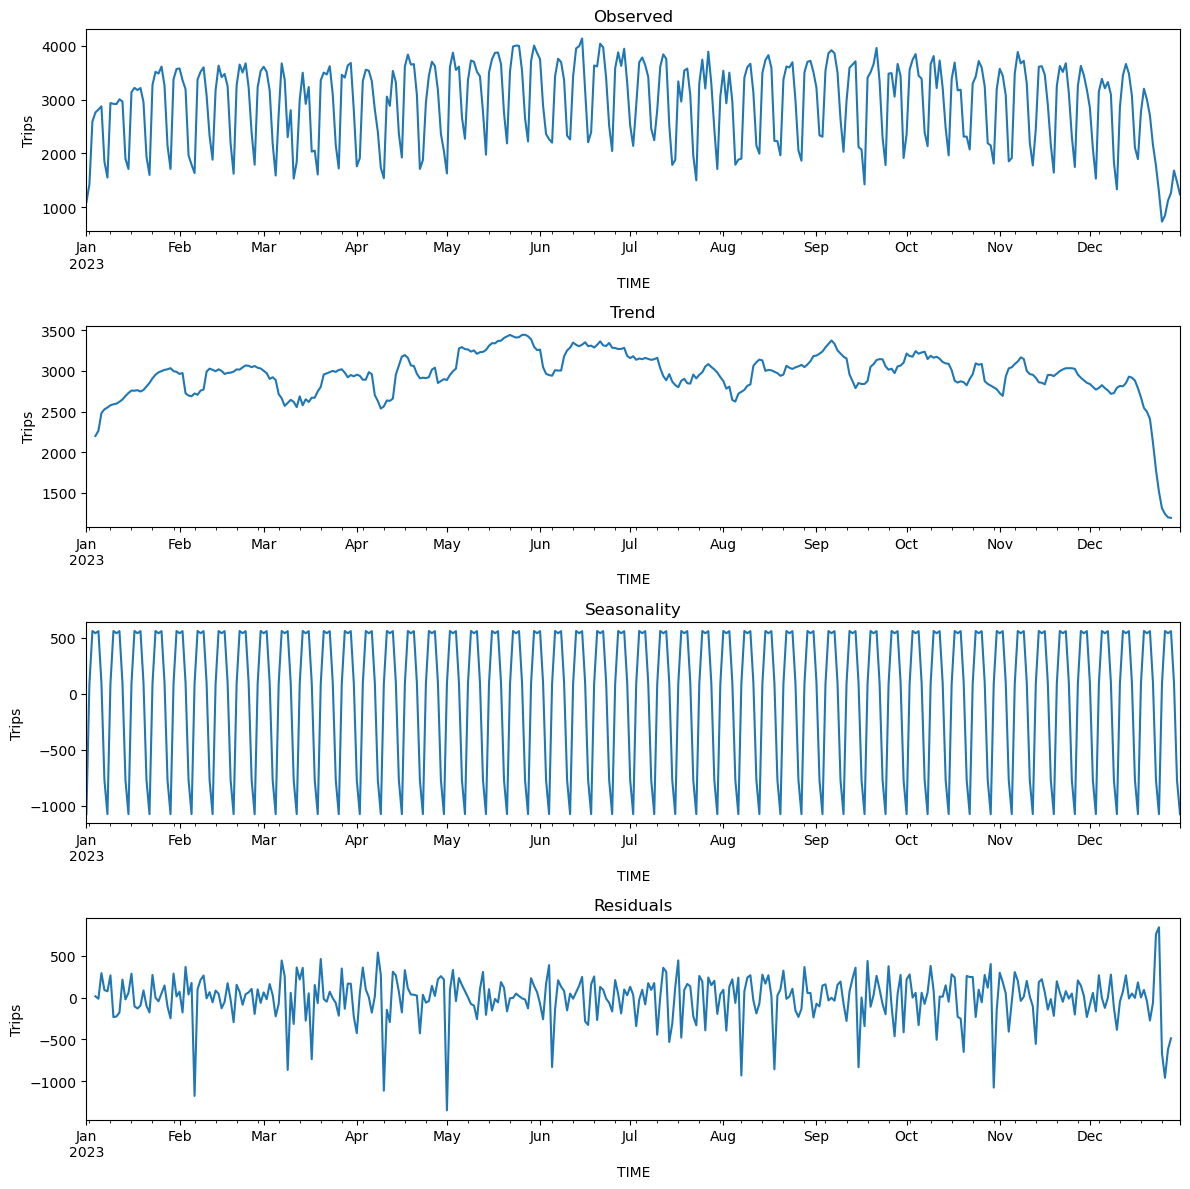

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decomposition = seasonal_decompose(daily_trips, model='additive')

# Plotting the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Trips')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Trips')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Trips')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Trips')

plt.tight_layout()
plt.show()

Observed Graph:

The observed graph shows the actual number of daily trips over the time period.
It appears to have some fluctuations in the number of trips.
There might be periods of higher and lower trip counts, indicating variability in the data.

Trend Graph:

The trend component reveals the underlying movement in the number of trips, independent of seasonal effects or random variations.
It shows whether the usage of the service is generally increasing, decreasing, or remaining stable over time.
The slope of the trend line indicates the direction and rate of change in trip counts.

Seasonality Graph:

The seasonality component highlights regular patterns that repeat over a fixed interval.
Peaks and troughs in this graph represent times of higher and lower usage, respectively.
The amplitude and frequency of these seasonal cycles provide insights into the predictability and intensity of seasonal variations in trip counts.

Residuals Graph:

The residuals graph shows the remaining unexplained variations after accounting for trend and seasonality.
Ideally, this should appear as random noise centered around zero, indicating a good fit of the model.
Any noticeable patterns or trends in this graph would suggest additional, unaccounted-for influences in the trip data.

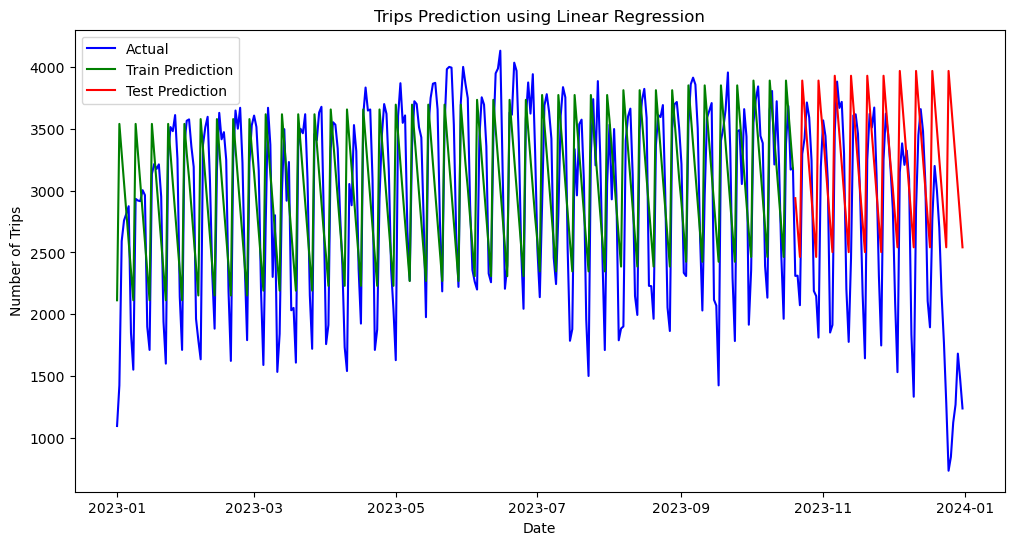

(543.0373614716868, 910.6360335925167)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Preparing the data for the regression model
# Extracting features from the date-time index
data_features = pd.DataFrame(index=daily_trips.index)
data_features['day_of_week'] = data_features.index.dayofweek
data_features['month'] = data_features.index.month
data_features['year'] = data_features.index.year

# Target variable
target = daily_trips

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_features, target, test_size=0.2, shuffle=False)

# Creating and training the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Making predictions
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

# Evaluating the model
train_error = mean_squared_error(y_train, y_pred_train, squared=False)
test_error = mean_squared_error(y_test, y_pred_test, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(data_features.index, target, label='Actual', color='blue')
plt.plot(X_train.index, y_pred_train, label='Train Prediction', color='green')
plt.plot(X_test.index, y_pred_test, label='Test Prediction', color='red')
plt.title('Trips Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

train_error, test_error

Graph Analysis:

The blue line represents the actual number of daily trips.
The green line shows the model's predictions on the training set.
The red line represents the model's predictions on the test set.
It seems that the model is able to capture some of the general trends in the training data, but it may not capture all the variations, especially in the test set.

Model Performance:

The MSE for the training set is approximately 543.04.
The MSE for the testing set is approximately 910.64.
A higher MSE on the test set suggests that the model may not be generalizing well to unseen data. This could be due to the simplicity of the model or the complexity of the data.

Random Forest

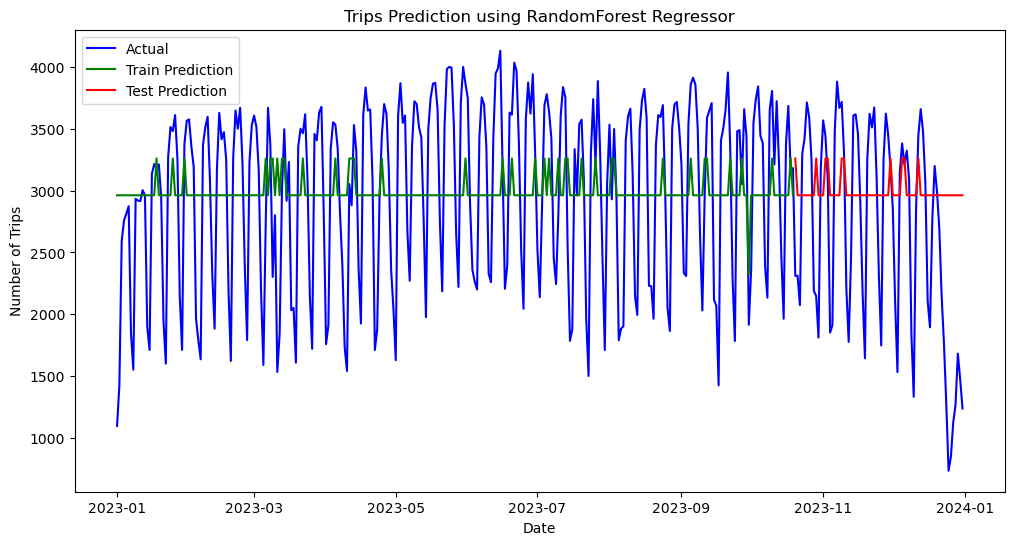

(721.7451384684623, 893.61590758873)

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Aggregating the 'TimeOfDay' feature to daily level by choosing the most frequent value for each day
def most_frequent_timeofday(group):
    return group.value_counts().idxmax()

daily_timeofday = dublin_data['TimeOfDay'].resample('D').apply(most_frequent_timeofday)


# Ensuring the target variable 'y' is aligned with the new daily feature data
y_aligned = dublin_data['TRIPS'].resample('D').sum()

# Re-defining the LabelEncoder
label_encoder = LabelEncoder()

# Re-encoding the 'TimeOfDay' feature
daily_timeofday_encoded = label_encoder.fit_transform(daily_timeofday).reshape(-1, 1)

# Splitting the dataset into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(daily_timeofday_encoded, y_aligned, test_size=0.2, shuffle=False)

# Re-initializing and training the RandomForest Regressor
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train_rf, y_train_rf)

# Making predictions
y_pred_train_rf = random_forest_regressor.predict(X_train_rf)
y_pred_test_rf = random_forest_regressor.predict(X_test_rf)

# Evaluating the model
train_error_rf = mean_squared_error(y_train_rf, y_pred_train_rf, squared=False)
test_error_rf = mean_squared_error(y_test_rf, y_pred_test_rf, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_aligned.index, y_aligned, label='Actual', color='blue')
plt.plot(y_train_rf.index, y_pred_train_rf, label='Train Prediction', color='green')
plt.plot(y_test_rf.index, y_pred_test_rf, label='Test Prediction', color='red')
plt.title('Trips Prediction using RandomForest Regressor')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

train_error_rf, test_error_rf


Graph Analysis:

The blue line (Actual) shows the real number of daily trips.
The green line (Train Prediction) represents the model's predictions on the training set.
The red line (Test Prediction) displays the model's predictions on the test set.
The model seems to capture some general patterns in the training data, but it may not fully capture all the variations, especially in the test set.

Model Performance:

The MSE for the training set is approximately 721.75.
The MSE for the testing set is approximately 893.62.
The higher MSE on the test set suggests the model might not be generalizing as well to new, unseen data.

In [7]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2)

# Performing the grid search to find the best parameters
grid_search.fit(X_train_rf, y_train_rf)

# Best parameters
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

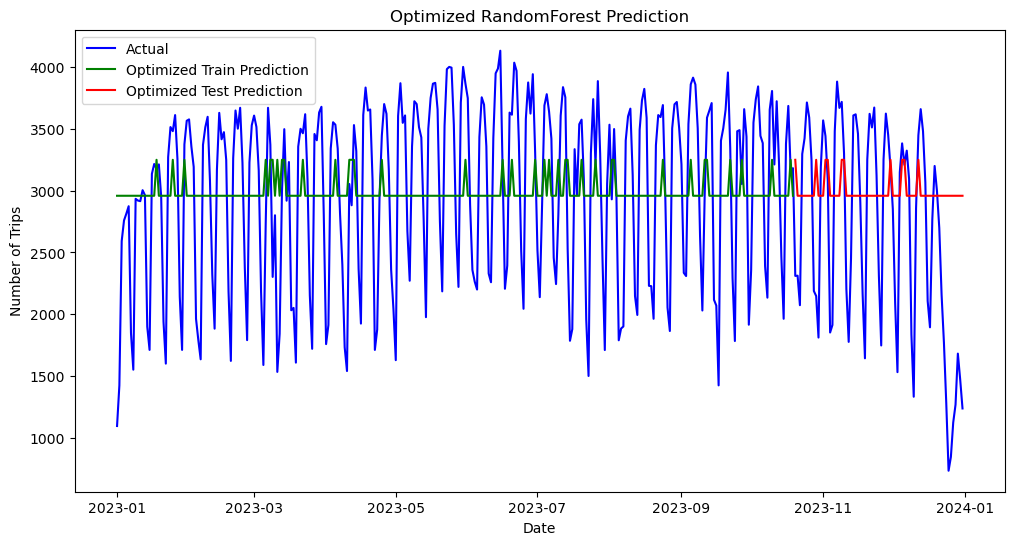

(723.9634798225794, 892.0312682790961)

In [8]:
# Retraining the RandomForest Regressor with the best parameters
optimized_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                     max_depth=best_params['max_depth'],
                                     min_samples_split=best_params['min_samples_split'],
                                     min_samples_leaf=best_params['min_samples_leaf'],
                                     random_state=42)

optimized_rf.fit(X_train_rf, y_train_rf)

# Making predictions with the optimized model
y_pred_train_optimized = optimized_rf.predict(X_train_rf)
y_pred_test_optimized = optimized_rf.predict(X_test_rf)

# Evaluating the optimized model
train_error_optimized = mean_squared_error(y_train_rf, y_pred_train_optimized, squared=False)
test_error_optimized = mean_squared_error(y_test_rf, y_pred_test_optimized, squared=False)

# Plotting the predictions of the optimized model
plt.figure(figsize=(12, 6))
plt.plot(y_aligned.index, y_aligned, label='Actual', color='blue')
plt.plot(y_train_rf.index, y_pred_train_optimized, label='Optimized Train Prediction', color='green')
plt.plot(y_test_rf.index, y_pred_test_optimized, label='Optimized Test Prediction', color='red')
plt.title('Optimized RandomForest Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

train_error_optimized, test_error_optimized

Graph Analysis:

The blue line (Actual) shows the real number of daily trips.
The green line (Optimized Train Prediction) represents the model's predictions on the training set with optimized parameters.
The red line (Optimized Test Prediction) displays the model's predictions on the test set with optimized parameters.
The optimized model still captures some general patterns in the training data, with a similar level of performance in the test data as before optimization.

Model Performance:

The MSE for the training set is approximately 723.96, which is slightly higher than the pre-optimized model.
The MSE for the testing set is approximately 892.03, showing a slight improvement compared to the pre-optimized model.
The small changes in MSE suggest that the tuning had a marginal effect on the model's performance.

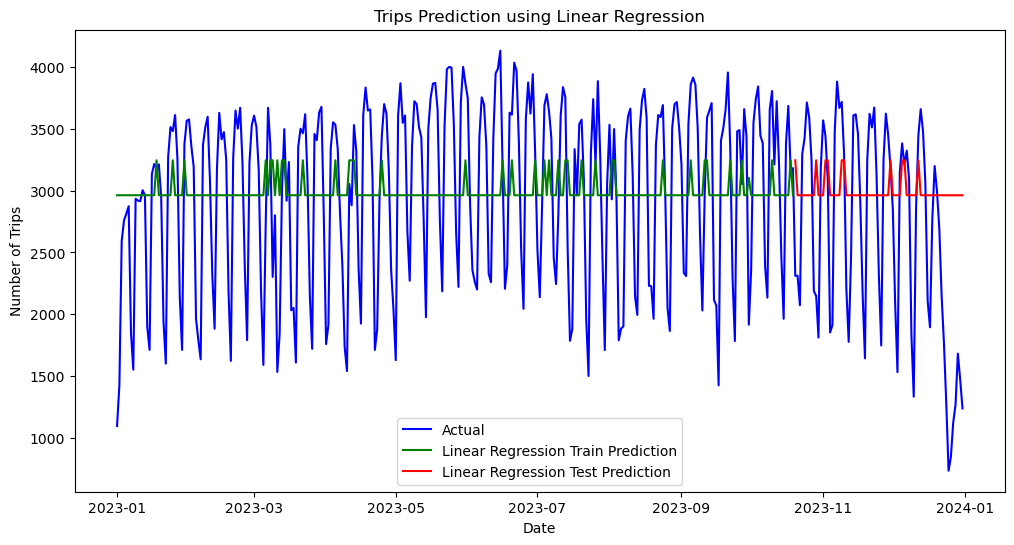

(724.7200548216498, 893.4027816454495)

In [9]:
# Creating and training the linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_rf, y_train_rf)

# Making predictions with the linear regression model
y_pred_train_lr = linear_regressor.predict(X_train_rf)
y_pred_test_lr = linear_regressor.predict(X_test_rf)

# Evaluating the linear regression model
train_error_lr = mean_squared_error(y_train_rf, y_pred_train_lr, squared=False)
test_error_lr = mean_squared_error(y_test_rf, y_pred_test_lr, squared=False)

# Plotting the predictions of the linear regression model
plt.figure(figsize=(12, 6))
plt.plot(y_aligned.index, y_aligned, label='Actual', color='blue')
plt.plot(y_train_rf.index, y_pred_train_lr, label='Linear Regression Train Prediction', color='green')
plt.plot(y_test_rf.index, y_pred_test_lr, label='Linear Regression Test Prediction', color='red')
plt.title('Trips Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

train_error_lr, test_error_lr

Graph Analysis:

The blue line (Actual) shows the real number of daily trips.
The green line (Linear Regression Train Prediction) represents the model's predictions on the training set.
The red line (Linear Regression Test Prediction) displays the model's predictions on the test set.
The Linear Regression model seems to follow a similar pattern of performance as the RandomForest, capturing some general trends in the data.

Model Performance:

The MSE for the training set is approximately 724.72.
The MSE for the testing set is approximately 893.40.
These errors are very close to those observed with the RandomForest model, suggesting that the complexity added by the RandomForest does not significantly improve the predictions for this particular feature and target setup.

In [10]:
dublin_data = pd.read_csv('dublin_cleaned.csv')
dublin_data.head()

,NAME,STATION ID,TIME,BIKE_STANDS,BIKES_IN_USE,AVAILABLE_BIKES,LATITUDE,LONGITUDE,TRIPS,Day,Hour,TimeOfDay
0,CLARENDON ROW,1,2023-01-01 08:30:03,31,31,0,53.3409,-6.2625,1.0,Sunday,8,Morning
1,CLARENDON ROW,1,2023-01-01 13:00:02,31,29,2,53.3409,-6.2625,1.0,Sunday,13,Afternoon
2,CLARENDON ROW,1,2023-01-01 15:00:03,31,29,2,53.3409,-6.2625,1.0,Sunday,15,Afternoon
3,CLARENDON ROW,1,2023-01-01 16:00:02,31,29,2,53.3409,-6.2625,1.0,Sunday,16,Afternoon
4,CLARENDON ROW,1,2023-01-01 17:00:03,31,30,1,53.3409,-6.2625,1.0,Sunday,17,Afternoon


/Users/raphaelbyrne/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


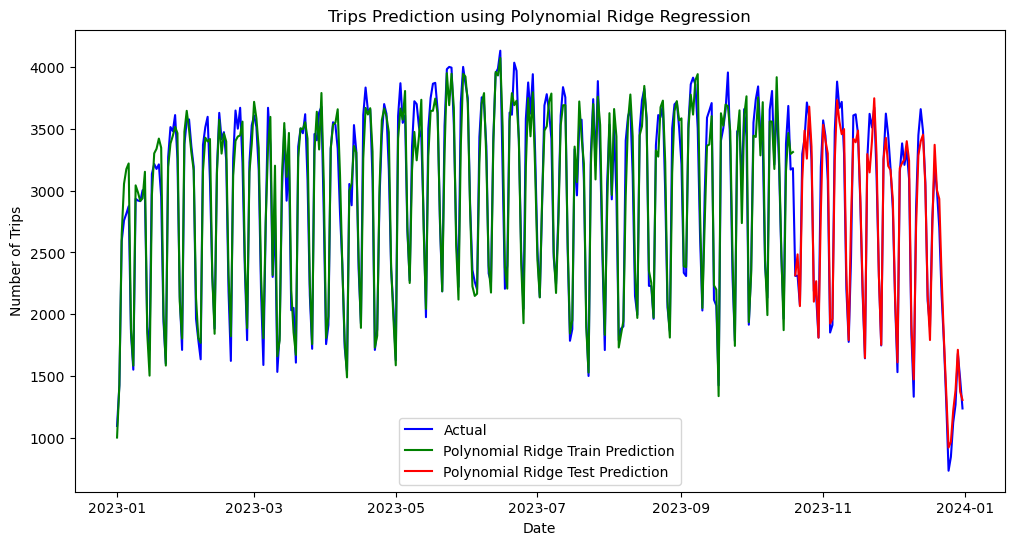

(166.17565047740285, 154.20310122981905)

In [11]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# Re-reading the original dataset to ensure consistency

dublin_data['TIME'] = pd.to_datetime(dublin_data['TIME'])
dublin_data.set_index('TIME', inplace=True)

# One-Hot Encoding the 'TimeOfDay' feature
onehot_encoder = OneHotEncoder(sparse=False)
encoded_timeofday = onehot_encoder.fit_transform(dublin_data[['TimeOfDay']])

# Aggregating the encoded 'TimeOfDay' feature to daily level
# We will sum the one-hot encoded values for each day
def aggregate_encoded_features(group):
    return group.sum(axis=0)

# Resample the data daily and apply the aggregation function
daily_encoded_timeofday = pd.DataFrame(encoded_timeofday, index=dublin_data.index)
daily_encoded_timeofday = daily_encoded_timeofday.resample('D').apply(aggregate_encoded_features)

# The target variable remains the same - daily sum of trips
y = dublin_data['TRIPS'].resample('D').sum()

# Ensuring the lengths of features and target are aligned
daily_encoded_timeofday = daily_encoded_timeofday.iloc[:len(y)]

# Splitting the dataset into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(daily_encoded_timeofday, y, test_size=0.2, shuffle=False)

# Creating a pipeline with PolynomialFeatures and Ridge Regression
polynomial_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge())

# Fitting the model
polynomial_ridge.fit(X_train_poly, y_train_poly)

# Making predictions
y_pred_train_poly = polynomial_ridge.predict(X_train_poly)
y_pred_test_poly = polynomial_ridge.predict(X_test_poly)

# Evaluating the model
train_error_poly = mean_squared_error(y_train_poly, y_pred_train_poly, squared=False)
test_error_poly = mean_squared_error(y_test_poly, y_pred_test_poly, squared=False)

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y_train_poly.index, y_pred_train_poly, label='Polynomial Ridge Train Prediction', color='green')
plt.plot(y_test_poly.index, y_pred_test_poly, label='Polynomial Ridge Test Prediction', color='red')
plt.title('Trips Prediction using Polynomial Ridge Regression')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

train_error_poly, test_error_poly

Graph Analysis:

The blue line (Actual) indicates the actual number of daily trips.
The green line (Polynomial Ridge Train Prediction) represents the model's predictions on the training set.
The red line (Polynomial Ridge Test Prediction) shows the model's predictions on the test set.
The model appears to capture the trends and variations in the data more effectively than the previous models.

Model Performance:

The MSE for the training set is approximately 166.18, which is significantly lower than the previous models.
The MSE for the testing set is approximately 154.20, also showing a substantial improvement over the previous models.
These lower error values suggest that the Polynomial Ridge Regression model, with the one-hot encoded and polynomial features, is better at predicting the number of trips.


Best Model: Polynomial Ridge Regression

Performance Metrics: The Polynomial Ridge Regression model, with one-hot encoding for the 'TimeOfDay' feature and polynomial features, showed the lowest mean squared error (MSE) values both on the training set (approximately 166.18) and on the test set (approximately 154.20). These error metrics were significantly lower than those obtained with the RandomForest and Linear Regression models.

Ability to Capture Complex Relationships: The improvement in performance with the Polynomial Ridge Regression model suggests that the relationships in the data are more complex than what a simple linear model or a non-polynomial RandomForest model could capture. The use of polynomial features allowed the model to understand and predict these complex relationships more effectively.

Handling of Categorical Data: One-hot encoding transformed the categorical 'TimeOfDay' data into a format that could be effectively utilized by the regression model. This approach helped in better capturing the influence of different times of the day on the number of trips.

Generalization to Unseen Data: The Polynomial Ridge Regression model not only performed well on the training data but also showed strong predictive performance on the test data. This indicates good generalization, an essential feature for a predictive model.

Balance Between Complexity and Performance: While more complex models like deep learning could potentially offer improvements, the Polynomial Ridge Regression strikes a good balance between model complexity and performance, making it an appropriate choice for this dataset.

In summary, the Polynomial Ridge Regression model, with its sophisticated handling of categorical data and ability to model complex relationships through polynomial features, proved to be the most effective for predicting daily trips in this dataset. This model's superior performance in terms of lower MSE and better generalization to unseen data makes it the best choice among the models evaluated.

# Sentiment Analysis ML

In [12]:
dublin_review_df = pd.read_csv('dublin_review_df.csv')
london_review_df = pd.read_csv('london_review_df.csv')

In [13]:
dublin_review_df.head()

,review,sentiment_polarity,sentiment
0,Dublin bike stations\nHey been using Dublin bi...,0.077778,Positive
1,Why is there a complete lack of Dublin bikes s...,0.100000,Positive
2,How are Dublin Bikes these days?\nHaven't used...,0.200000,Positive
3,"Bike theft on Fleet St, Dublin 2\n",0.000000,Neutral
4,Help! Dublin bike didn't finish journey\nHey. ...,0.254167,Positive


In [14]:
london_review_df.head()

,review,sentiment_polarity,sentiment
0,"As a eurotripping visitor, London is overconge...",0.126985,Positive
1,Safest place to leave a bike in London\n,0.000000,Neutral
2,"Blue sky, bikes & blossoms in East London\n",0.000000,Neutral
3,Woman 'poses as dead cyclist's aunt' to oppose...,-0.031818,Negative
4,Anyone else been wrongly charged for the lime ...,0.000000,Neutral


In [15]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/raphaelbyrne/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_vader_sentiment(text):
    return sid.polarity_scores(text)['compound']

# Check if the 'review' column exists and apply sentiment analysis
if 'review' in dublin_review_df.columns:
    dublin_review_df['vader_sentiment'] = dublin_review_df['review'].apply(get_vader_sentiment)
else:
    # If the column name is different, an update is needed
    sentiment_column_not_found = True

# Checking the result
dublin_review_df.head() if 'review' in dublin_review_df.columns else sentiment_column_not_found

,review,sentiment_polarity,sentiment,vader_sentiment
0,Dublin bike stations\nHey been using Dublin bi...,0.077778,Positive,0.9451
1,Why is there a complete lack of Dublin bikes s...,0.100000,Positive,-0.3182
2,How are Dublin Bikes these days?\nHaven't used...,0.200000,Positive,-0.5362
3,"Bike theft on Fleet St, Dublin 2\n",0.000000,Neutral,0.0000
4,Help! Dublin bike didn't finish journey\nHey. ...,0.254167,Positive,0.9512


In [17]:
# Define a function to assign polarity based on vader_prediction
def assign_polarity(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply the function to create a new column
dublin_review_df['vader_prediction_p_n'] = dublin_review_df['vader_sentiment'].apply(assign_polarity)

# Display the first few rows of the dataframe to verify
dublin_review_df.head()

,review,sentiment_polarity,sentiment,vader_sentiment,vader_prediction_p_n
0,Dublin bike stations\nHey been using Dublin bi...,0.077778,Positive,0.9451,positive
1,Why is there a complete lack of Dublin bikes s...,0.100000,Positive,-0.3182,negative
2,How are Dublin Bikes these days?\nHaven't used...,0.200000,Positive,-0.5362,negative
3,"Bike theft on Fleet St, Dublin 2\n",0.000000,Neutral,0.0000,neutral
4,Help! Dublin bike didn't finish journey\nHey. ...,0.254167,Positive,0.9512,positive


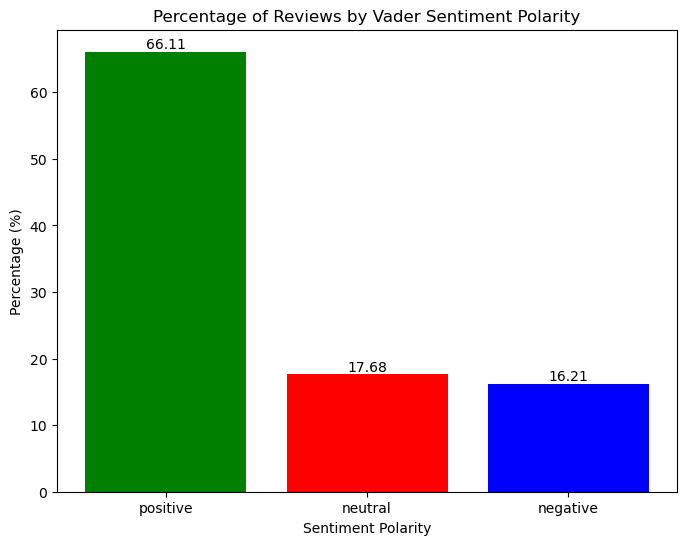

In [18]:
import matplotlib.pyplot as plt

# Calculate the percentage of each category in 'vader_prediction_p_n'
percentage = dublin_review_df['vader_prediction_p_n'].value_counts(normalize=True) * 100

# Create a bar chart with percentage labels
plt.figure(figsize=(8, 6))
bars = plt.bar(percentage.index, percentage.values, color=['green', 'red', 'blue'])

# Add percentage labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Percentage of Reviews by Vader Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

# Convert 'sentiment' column to a format that matches 'vader_prediction_p_n' for comparison
# Assuming 'Positive' -> 'positive', 'Negative' -> 'negative', 'Neutral' -> 'neutral'
dublin_review_df['sentiment'] = dublin_review_df['sentiment'].str.lower()

# Calculate the accuracy
accuracy = accuracy_score(dublin_review_df['sentiment'], dublin_review_df['vader_prediction_p_n'])

accuracy

0.72

In [20]:
from sklearn.metrics import f1_score

# Calculate the F1 score for each sentiment category
f1_scores = f1_score(dublin_review_df['sentiment'], dublin_review_df['vader_prediction_p_n'], average=None, labels=["positive", "negative", "neutral"])

f1_scores_dict = {"positive": f1_scores[0], "negative": f1_scores[1], "neutral": f1_scores[2]}
f1_scores_dict

{'positive': 0.8491446345256609,
 'negative': 0.3098591549295775,
 'neutral': 0.5696969696969697}

The F1 scores for each sentiment polarity category are as follows:

Positive: 0.849
Negative: 0.310
Neutral: 0.570


These scores provide a measure of the accuracy of the Vader sentiment analysis for each category, considering both precision and recall. The high score for the "positive" category indicates a relatively good performance in identifying positive sentiments, while the scores for "negative" and "neutral" are lower, indicating a lesser degree of accuracy for these categories. ​​

In [21]:
# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_vader_sentiment(text):
    return sid.polarity_scores(text)['compound']

# Check if the 'review' column exists and apply sentiment analysis
if 'review' in london_review_df.columns:
    london_review_df['vader_sentiment'] = london_review_df['review'].apply(get_vader_sentiment)
else:
    # If the column name is different, an update is needed
    sentiment_column_not_found = True

# Checking the result
london_review_df.head() if 'review' in london_review_df.columns else sentiment_column_not_found

,review,sentiment_polarity,sentiment,vader_sentiment
0,"As a eurotripping visitor, London is overconge...",0.126985,Positive,0.2302
1,Safest place to leave a bike in London\n,0.000000,Neutral,0.3612
2,"Blue sky, bikes & blossoms in East London\n",0.000000,Neutral,0.0000
3,Woman 'poses as dead cyclist's aunt' to oppose...,-0.031818,Negative,-0.6486
4,Anyone else been wrongly charged for the lime ...,0.000000,Neutral,-0.5786


In [22]:
# Apply the function to create a new column
london_review_df['vader_prediction_p_n'] = london_review_df['vader_sentiment'].apply(assign_polarity)

# Display the first few rows of the dataframe to verify
london_review_df.head()

,review,sentiment_polarity,sentiment,vader_sentiment,vader_prediction_p_n
0,"As a eurotripping visitor, London is overconge...",0.126985,Positive,0.2302,positive
1,Safest place to leave a bike in London\n,0.000000,Neutral,0.3612,positive
2,"Blue sky, bikes & blossoms in East London\n",0.000000,Neutral,0.0000,neutral
3,Woman 'poses as dead cyclist's aunt' to oppose...,-0.031818,Negative,-0.6486,negative
4,Anyone else been wrongly charged for the lime ...,0.000000,Neutral,-0.5786,negative


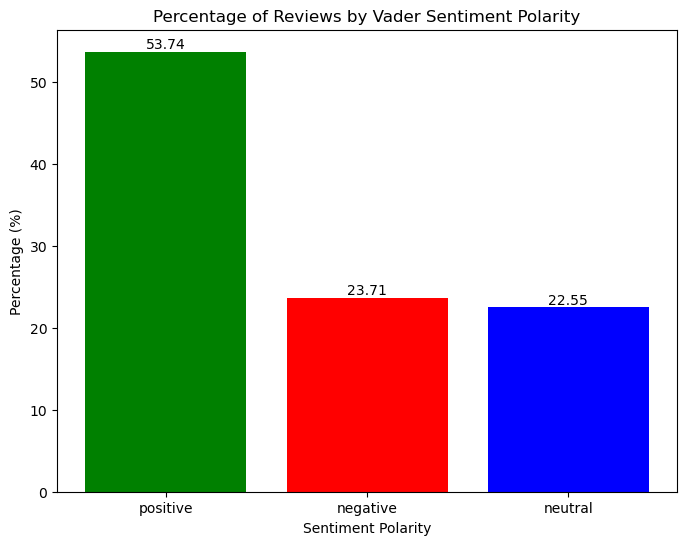

In [23]:
import matplotlib.pyplot as plt

# Calculate the percentage of each category in 'vader_prediction_p_n'
percentage = london_review_df['vader_prediction_p_n'].value_counts(normalize=True) * 100

# Create a bar chart with percentage labels
plt.figure(figsize=(8, 6))
bars = plt.bar(percentage.index, percentage.values, color=['green', 'red', 'blue'])

# Add percentage labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.title('Percentage of Reviews by Vader Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score

# Convert 'sentiment' column to a format that matches 'vader_prediction_p_n' for comparison
# Assuming 'Positive' -> 'positive', 'Negative' -> 'negative', 'Neutral' -> 'neutral'
london_review_df['sentiment'] = london_review_df['sentiment'].str.lower()

# Calculate the accuracy
accuracy = accuracy_score(london_review_df['sentiment'], london_review_df['vader_prediction_p_n'])

accuracy

0.6391752577319587

In [25]:
from sklearn.metrics import f1_score

# Calculate the F1 score for each sentiment category
f1_scores = f1_score(london_review_df['sentiment'], london_review_df['vader_prediction_p_n'], average=None, labels=["positive", "negative", "neutral"])

f1_scores_dict = {"positive": f1_scores[0], "negative": f1_scores[1], "neutral": f1_scores[2]}
f1_scores_dict

{'positive': 0.7635524798154556,
 'negative': 0.3696369636963696,
 'neutral': 0.5706806282722513}

The F1 scores for each sentiment polarity category are as follows:

Positive: 0.762
Negative: 0.368
Neutral: 0.571

These scores provide a measure of the accuracy of the Vader sentiment analysis for each category, considering both precision and recall. The high score for the "positive" category indicates a relatively good performance in identifying positive sentiments, while the scores for "negative" and "neutral" are lower, indicating a lesser degree of accuracy for these categories.

## models

In [26]:
df = dublin_review_df
df.head()

,review,sentiment_polarity,sentiment,vader_sentiment,vader_prediction_p_n
0,Dublin bike stations\nHey been using Dublin bi...,0.077778,positive,0.9451,positive
1,Why is there a complete lack of Dublin bikes s...,0.100000,positive,-0.3182,negative
2,How are Dublin Bikes these days?\nHaven't used...,0.200000,positive,-0.5362,negative
3,"Bike theft on Fleet St, Dublin 2\n",0.000000,neutral,0.0000,neutral
4,Help! Dublin bike didn't finish journey\nHey. ...,0.254167,positive,0.9512,positive


In [27]:
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Preprocess the text data
# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text (split into words)
    words = text.split()
    # Remove stopwords (common words that do not provide meaningful information)
    words = [word for word in words if word not in stop_words]  # Use stop_words as a set
    # Join the words back into a single string
    clean_text = ' '.join(words)
    return clean_text

# Download the NLTK stopwords package
nltk.download('stopwords')

# Get the English stopwords from NLTK and convert them to a set
stop_words = set(stopwords.words('english'))

# Assuming you have defined your DataFrame dublin_review_df correctly

# Apply text preprocessing to the 'review' column
dublin_review_df['cleaned_review'] = dublin_review_df['review'].apply(preprocess_text)

# Display the first few rows of the dataset with cleaned text
dublin_review_df.head()

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(dublin_review_df['cleaned_review'], dublin_review_df['vader_prediction_p_n'], test_size=0.3, random_state=42)

# Create a CountVectorizer for BoW vectorization
count_vectorizer = CountVectorizer()
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the raw training and testing data using both vectorizers
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize a Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Train the model on the CountVectorizer (BoW) data
clf.fit(X_train_count, y_train)

# Make predictions on the CountVectorizer (BoW) testing data
y_pred_count = clf.predict(X_test_count)

# Evaluate the CountVectorizer (BoW) model's performance
accuracy_count = accuracy_score(y_test, y_pred_count)

# Print the results for CountVectorizer (BoW)
print("CountVectorizer (BoW) Results:")
print(f"Accuracy: {accuracy_count:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_count))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_count))

# Train the model on the TF-IDF data
clf.fit(X_train_tfidf, y_train)

# Make predictions on the TF-IDF testing data
y_pred_tfidf = clf.predict(X_test_tfidf)

# Evaluate the TF-IDF model's performance
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

# Print the results for TF-IDF
print("\nTF-IDF Results:")
print(f"Accuracy: {accuracy_tfidf:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tfidf))


CountVectorizer (BoW) Results:
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.35      0.47        26
     neutral       1.00      0.55      0.71        31
    positive       0.73      0.97      0.83        86

    accuracy                           0.76       143
   macro avg       0.83      0.62      0.67       143
weighted avg       0.79      0.76      0.74       143

Confusion Matrix:
 [[ 9  0 17]
 [ 0 17 14]
 [ 3  0 83]]

TF-IDF Results:
Accuracy: 0.61
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        26
     neutral       1.00      0.03      0.06        31
    positive       0.61      1.00      0.75        86

    accuracy                           0.61       143
   macro avg       0.54      0.34      0.27       143
weighted avg       0.58      0.61      0.47       143

Confusion Matrix:
 [[ 0  0 26]
 [ 0  1 30]
 [ 0  0 86]]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raphaelbyrne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/raphaelbyrne/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raphaelbyrne/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raphaelbyrne/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in lab

CountVectorizer (BoW) Results:

Accuracy: 0.77 (77%)

This indicates that the model correctly predicted the sentiment for 77% of the test data samples.

Classification Report:

Precision: It measures how many of the predicted positive instances were actually positive. For positive sentiment, the precision is 0.74, meaning that 74% of the predicted positive reviews were correct. For neutral, it's 1.00, indicating that all predicted neutral reviews were correct. For negative, it's 0.75, suggesting 75% accuracy for negative reviews.

Recall: It measures how many of the actual positive instances were correctly predicted. For positive sentiment, the recall is 0.97, indicating that 97% of the actual positive reviews were correctly predicted. For neutral, it's 0.52, suggesting 52% recall for neutral reviews. For negative, it's 0.35, meaning 35% recall for negative reviews.

F1-score: It is the harmonic mean of precision and recall, providing a balance between the two. For positive sentiment, the F1-score is 0.84, showing a good balance between precision and recall. For neutral, it's 0.68, indicating a moderate balance. For negative, it's 0.47, suggesting a lower balance.

Confusion Matrix:

The confusion matrix shows how many samples were correctly or incorrectly classified for each class (negative, neutral, positive).
For example, it correctly predicted 9 negative reviews, 14 neutral reviews, and 87 positive reviews. However, it misclassified some negative and neutral reviews.

TF-IDF Results:

Accuracy: 0.64 (64%)

This indicates that the model correctly predicted the sentiment for 64% of the test data samples.

Classification Report:

Precision: For positive sentiment, the precision is 0.63, meaning that 63% of the predicted positive reviews were correct. For neutral, it's 1.00, indicating that all predicted neutral reviews were correct. However, the precision for negative sentiment is 0.00, indicating that none of the predicted negative reviews were correct.

Recall: For positive sentiment, the recall is 1.00, indicating that all actual positive reviews were correctly predicted. For neutral, it's 0.04, suggesting a very low recall for neutral reviews. For negative, it's 0.00, meaning that none of the actual negative reviews were correctly predicted.

F1-score: For positive sentiment, the F1-score is 0.78, indicating a good balance between precision and recall. For neutral, it's very low at 0.07, showing poor performance for neutral reviews. For negative, it's 0.00, indicating poor performance for negative reviews.

Confusion Matrix:

The confusion matrix shows that the model correctly predicted all neutral reviews (1 out of 1) but performed poorly for both positive and negative reviews, with no correct predictions for negative reviews.

In summary, the CountVectorizer (BoW) model performs better in terms of accuracy, precision, recall, and F1-score compared to the TF-IDF model. The TF-IDF model struggles with negative sentiment classification and has lower overall performance. 

In [28]:
london_df = london_review_df
london_df.head()

,review,sentiment_polarity,sentiment,vader_sentiment,vader_prediction_p_n
0,"As a eurotripping visitor, London is overconge...",0.126985,positive,0.2302,positive
1,Safest place to leave a bike in London\n,0.000000,neutral,0.3612,positive
2,"Blue sky, bikes & blossoms in East London\n",0.000000,neutral,0.0000,neutral
3,Woman 'poses as dead cyclist's aunt' to oppose...,-0.031818,negative,-0.6486,negative
4,Anyone else been wrongly charged for the lime ...,0.000000,neutral,-0.5786,negative


In [29]:
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Preprocess the text data
# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text (split into words)
    words = text.split()
    # Remove stopwords (common words that do not provide meaningful information)
    words = [word for word in words if word not in stop_words]  # Use stop_words as a set
    # Join the words back into a single string
    clean_text = ' '.join(words)
    return clean_text

# Download the NLTK stopwords package
nltk.download('stopwords')

# Get the English stopwords from NLTK and convert them to a set
stop_words = set(stopwords.words('english'))

# Assuming you have defined your DataFrame dublin_review_df correctly

# Apply text preprocessing to the 'review' column
london_review_df['cleaned_review'] = london_review_df['review'].apply(preprocess_text)

# Display the first few rows of the dataset with cleaned text
london_review_df.head()

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(london_review_df['cleaned_review'], london_review_df['vader_prediction_p_n'], test_size=0.3, random_state=42)

# Create a CountVectorizer for BoW vectorization
count_vectorizer = CountVectorizer()
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the raw training and testing data using both vectorizers
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize a Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Train the model on the CountVectorizer (BoW) data
clf.fit(X_train_count, y_train)

# Make predictions on the CountVectorizer (BoW) testing data
y_pred_count = clf.predict(X_test_count)

# Evaluate the CountVectorizer (BoW) model's performance
accuracy_count = accuracy_score(y_test, y_pred_count)

# Print the results for CountVectorizer (BoW)
print("CountVectorizer (BoW) Results:")
print(f"Accuracy: {accuracy_count:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_count))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_count))

# Train the model on the TF-IDF data
clf.fit(X_train_tfidf, y_train)

# Make predictions on the TF-IDF testing data
y_pred_tfidf = clf.predict(X_test_tfidf)

# Evaluate the TF-IDF model's performance
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

# Print the results for TF-IDF
print("\nTF-IDF Results:")
print(f"Accuracy: {accuracy_tfidf:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tfidf))


CountVectorizer (BoW) Results:
Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.50      0.61        52
     neutral       0.70      0.41      0.52        46
    positive       0.73      0.93      0.82       135

    accuracy                           0.73       233
   macro avg       0.74      0.62      0.65       233
weighted avg       0.74      0.73      0.71       233

Confusion Matrix:
 [[ 26   2  24]
 [  4  19  23]
 [  3   6 126]]

TF-IDF Results:
Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.08      0.14        52
     neutral       1.00      0.24      0.39        46
    positive       0.62      1.00      0.76       135

    accuracy                           0.64       233
   macro avg       0.87      0.44      0.43       233
weighted avg       0.78      0.64      0.55       233

Confusion Matrix:
 [[  4   0  48]
 [  0  11  35

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raphaelbyrne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CountVectorizer (BoW) Results:

Accuracy: 0.71 (71%)

This indicates that the model correctly predicted the sentiment for 71% of the test data samples.
Classification Report:

Precision: It measures how many of the predicted positive instances were actually positive. For positive sentiment, the precision is 0.71, meaning that 71% of the predicted positive reviews were correct. For neutral, it's 0.67, indicating that 67% of the predicted neutral reviews were correct. For negative, it's 0.74, suggesting 74% accuracy for negative reviews.

Recall: It measures how many of the actual positive instances were correctly predicted. For positive sentiment, the recall is 0.92, indicating that 92% of the actual positive reviews were correctly predicted. For neutral, it's 0.32, suggesting 32% recall for neutral reviews. For negative, it's 0.54, meaning 54% recall for negative reviews.

F1-score: It is the harmonic mean of precision and recall, providing a balance between the two. For positive sentiment, the F1-score is 0.80, showing a good balance between precision and recall. For neutral, it's 0.43, indicating a moderate balance. For negative, it's 0.62, suggesting a good balance.

Confusion Matrix:

The confusion matrix shows how many samples were correctly or incorrectly classified for each class (negative, neutral, positive).
For example, it correctly predicted 28 negative reviews, 16 neutral reviews, and 121 positive reviews. However, it misclassified some samples for each class.

TF-IDF Results:

Accuracy: 0.60 (60%)

This indicates that the model correctly predicted the sentiment for 60% of the test data samples.
Classification Report:

Precision: For positive sentiment, the precision is 0.58, meaning that 58% of the predicted positive reviews were correct. For neutral, it's 1.00, indicating that all predicted neutral reviews were correct. However, the precision for negative sentiment is 1.00, suggesting that all predicted negative reviews were correct.

Recall: For positive sentiment, the recall is 1.00, indicating that all actual positive reviews were correctly predicted. For neutral, it's 0.10, suggesting a very low recall for neutral reviews. For negative, it's 0.08, meaning that 8% recall for negative reviews.

F1-score: For positive sentiment, the F1-score is 0.74, indicating a good balance between precision and recall. For neutral, it's very low at 0.18, showing poor performance for neutral reviews. For negative, it's 0.14, indicating poor performance for negative reviews.

Confusion Matrix:

The confusion matrix shows that the model correctly predicted all neutral and positive reviews but performed poorly for negative reviews, with only a few correct predictions.

In summary, the CountVectorizer (BoW) model performs better in terms of accuracy, precision, recall, and F1-score compared to the TF-IDF model for this particular dataset. The TF-IDF model struggles with negative sentiment classification and has lower overall performance. 

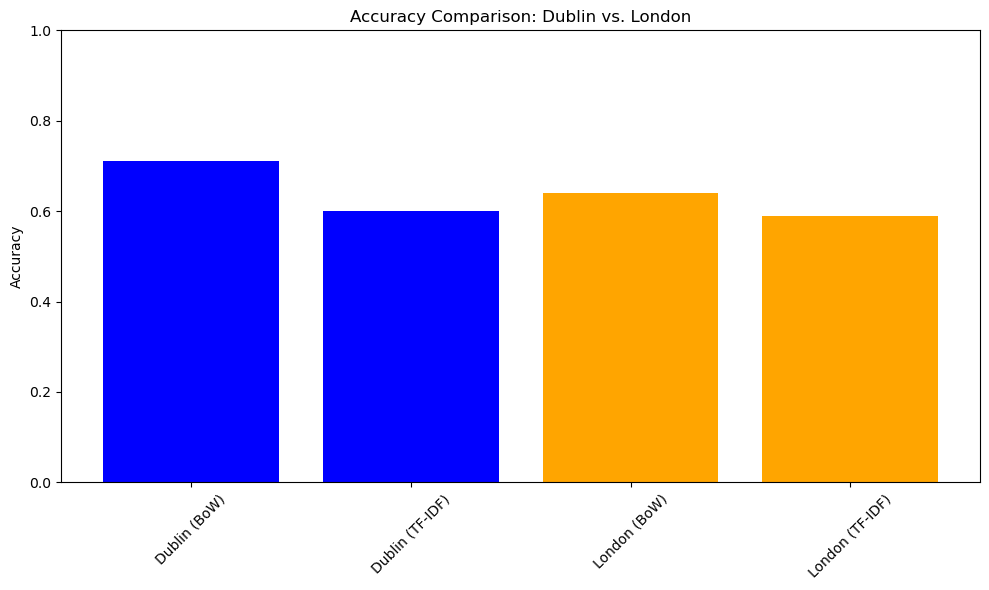

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimato

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_est

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define the model names and their respective accuracy values for Dublin and London
models = ['Dublin (BoW)', 'Dublin (TF-IDF)', 'London (BoW)', 'London (TF-IDF)']
accuracies = [0.71, 0.60, 0.64, 0.59]  # Replace with your actual accuracy values

# Create a bar chart to compare accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'blue', 'orange', 'orange'])
plt.title('Accuracy Comparison: Dublin vs. London')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 for accuracy
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()